# Scheduling and power control for Intercell Interference Coordination (ICIC)

## Setup parameters

In [1]:
# basic setup 

from pprint import pprint as pp
import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt 

timeslot_length = 0.01 # in seconds

shannon_discount_dB = 0.5 # in dB
shannon_discount = 10**(shannon_discount_dB/10)

bandwidth = 9*10**6 # bandwidth for an LTE setup 
noise_dBm = -95  # for a 9MHz channel , comprising thermal and device noise. this is total noise floor  
noise_mW = 10**(noise_dBm/10)

frequency = 2*10**9 # main carrier, in Hz  

transmit_power_dBm = 40 # no antenna gain, but some losses 
antenna_gain_dB = 0
cable_loss_dB = 0
eirp_dBm = transmit_power_dBm + antenna_gain_dB + cable_loss_dB

dB = lambda x: 10*np.log10(x)


## Factory for various path-loss models

In [2]:
# Path loss functions 
def path_loss_factory(type):
    """path loss in db"""
    def path_loss_okumura_hata(distance):
        """distance in km"""
        return const1 + const2*np.log10(distance) 

    if type=="suburban_indoor":
        hb = 50 # base station height in meter
        f = frequency/1000000 # we need frequency in MHz here 
        hm = 1.5 # mobile height in meter

        CH = 0.8 + (1.1*np.log10(f) - 0.7)*hm - 1.56*np.log10(f) 
    else:
        raise NotImplemented 
    
    const1 = 69.55 + 26.16*np.log10(f) - 13.82*np.log10(hb) - CH
    const2 = 44.9 - 6.55 * np.log10(hb)
    return path_loss_okumura_hata


def received_power(path_loss_db, eirp_dBm=eirp_dBm):
    """input in db / dbm. Output in mW """
    return 10**((eirp_dBm -path_loss_db)/10)



## Compute data rates from SINR, factory for various models

In [3]:
# Compute data rates 

def data_rate_factory(type):
    """map SINR to data rate"""

    def discounted_shannon(sinr_db,
                               bandwidth=bandwidth,
                               shannon_discount_dB=shannon_discount_dB):
        discounted_sinr = 10**((sinr_db - shannon_discount_dB)/10)
        return bandwidth * np.log10(1 + discounted_sinr)

    if type=="discounted_shannon":
        return discounted_shannon
    else:
        raise NotImplemented
    
def data_volume(data_rate, timeslot_length=timeslot_length):
    return data_rate*timeslot_length 



## Scenario setup 

Where are which terminals? Compute distances between them

TODO: refactor as proper class? Storing the scenario as a member variable? 

In [4]:
# Setup scenario 
from collections import defaultdict 

class scenario:
    def random_setup():
        return {}
    
    def icic_line():
        sc = {'A': (0,0), 
               'B': (1,0), 
               'An': (0-0.2, 0), 
               'Af': (0.49, 0), 
               'Bf': (0.51, 0), 
               'Bn': (1+0.2, 0), 
               }
        
        dist = scenario.get_distances(sc)
        return (sc, dist) 

    def get_distances(sc):
        dist = defaultdict(dict)
        for k1, v1 in sc.items():
            for k2, v2 in sc.items():
                dist[k1][k2] = ( (v1[0] - v2[0])**2 + (v1[1] - v2[1])**2 )**0.5
                    
        return dist


## Schedules 

Simple, straightforward approach: A schedule is a 
* dict of timeslots
* which contains a a dict of frequency bands 
* which contains a list of transmissions, represented as a three-tuple: sender, receiver and transmission power (in dBm!!)

Advantage: to compute interference, we just need to look at such a list. No need to look at matrices over all terminals, etc.  Disavantage: Sloooow. In particular, the dicts should probably be replaced by lists. 

TODO: refactor into a proper class that behaves like a generator? rather than a staitic method thatis a generaotr? (maybe matter of taste)

In [5]:
class Schedule: 
    """Schedules: dict of timeslot, frequency, list of (sender, receiver, power)
    
    Note: power is in dbm!!"""
    def simple_icic(): 
        return {1: {1: [("A", 'An', 1), ("B", 'Bn', 1) ]},
                2: {1: [("A", 'Af', 1), ("B", 'Bf', 1) ]},
                3: {1: [("A", 'An', 1), ("B", 'Bf', 1) ]},
                4: {1: [("A", 'An', 5), ("B", 'Bf', 1) ]},
                5: {1: [("A", 'An', 0.1), ("B", 'Bf', 1) ]},
               }
    
    def calibrate():
        """just for error checking"""
        return {
                   1: {1: [('A', 'An', 1)]},
               }
    
    def icic_generator():
        """Return schedule name, schedule tuples 
        
        Note: power is in dbm!!"""

        yield ("ULDL, T4,F1, shifted, Peq",
               {
                   1: {1: [('A', 'An', dB(10)), ('Bf', 'B', dB(10))]},
                   2: {1: [('A', 'Af', dB(10)), ('Bn', 'B', dB(10))]},
                   3: {1: [('An', 'A', dB(10)), ('B', 'Bf', dB(10))]},
                   4: {1: [('Af', 'A', dB(10)), ('B', 'Bn', dB(10))]},

               })

        yield ("ULDL, T4,F1, shifted, Phet",
               {
                   1: {1: [('A', 'An', dB(5)), ('Bf', 'B', dB(15))]},
                   2: {1: [('A', 'Af', dB(15)), ('Bn', 'B', dB(5))]},
                   3: {1: [('An', 'A', dB(5)), ('B', 'Bf', dB(15))]},
                   4: {1: [('Af', 'A', dB(15)), ('B', 'Bn', dB(10))]},

               })


        yield ("ULDL, T4,F1, homo, Peq",
               {
                   1: {1: [('A', 'An', dB(10)), ('B', 'Bn', dB(10))]},
                   2: {1: [('A', 'Af', dB(10)), ('B', 'Bf', dB(10))]},
                   3: {1: [('An', 'A', dB(10)), ('Bn', 'B', dB(10))]},
                   4: {1: [('Af', 'A', dB(10)), ('Bf', 'B', dB(10))]},

               })


        yield ("ULDL, T4,F1, homo, Phet",
               {
                   1: {1: [('A', 'An', dB(5)), ('B', 'Bn', dB(5))]},
                   2: {1: [('A', 'Af', dB(15)), ('B', 'Bf', dB(15))]},
                   3: {1: [('An', 'A', dB(5)), ('Bn', 'B', dB(5))]},
                   4: {1: [('Af', 'A', dB(15)), ('Bf', 'B', dB(15))]},

               })


        return
        
        yield ("T2,F1,nf,fn,Peq",
               {
                   1: {1: [('A', 'An', dB(10)), ('B', 'Bf', dB(10))]},
                   2: {1: [('A', 'Af', dB(10)), ('B', 'Bn', dB(10))]},
               })
        
        yield ("T2,F1,nn,ff,Pdiff",
               {
                   1: {1: [('A', 'An', dB(1)), ('B', 'Bn', dB(19))]},
                   2: {1: [('A', 'Af', dB(19)), ('B', 'Bf', dB(1))]},
               }
              )
        
        yield ("T2,F1,nf,fn,Pdiff",
               {
                   1: {1: [('A', 'An', dB(1)), ('B', 'Bf', dB(19))]},
                   2: {1: [('A', 'Af', dB(19)), ('B', 'Bn', dB(1))]},
               }
              )
        
        yield ("T2,F1, Phet",
               {
                   1: {1: [('A', 'An', dB(1)), ('B', 'Bn', dB(1))]},
                   2: {1: [('A', 'Af', dB(19)), ('B', 'Bf', dB(19))]},
               }
              )

        yield ("T1,F2,ICIC",
               {
                   1: {1: [('A', 'Af', dB(19)), ('B', 'Bn', dB(1))],
                       2: [('B', 'Bf', dB(19)), ('A', 'An', dB(1))],
                      },
               }
              )
        
        yield ("capmax",
               {
                   1: {1: [('A', 'An', dB(20)),]},
               }
              )

       
        return
        
        yield ("T4,F1,P1",
               {
                   1: {1: [('A', 'An', dB(10))]},
                   2: {1: [('A', 'Af', dB(10))]},
                   3: {1: [('B', 'Bn', dB(10))]},
                   4: {1: [('B', 'Bf', dB(10))]},
               }
              )
        
    
        yield ("T4,F1,P2",
               {
                   1: {1: [('A', 'An', dB(20))]},
                   2: {1: [('A', 'Af', dB(20))]},
                   3: {1: [('B', 'Bn', dB(20))]},
                   4: {1: [('B', 'Bf', dB(20))]},
               }
              )

        yield ("T4,F1,P.1",
               {
                   1: {1: [('A', 'An', dB(1))]},
                   2: {1: [('A', 'Af', dB(1))]},
                   3: {1: [('B', 'Bn', dB(1))]},
                   4: {1: [('B', 'Bf', dB(1))]},
               }
              )
    
        yield ("T2,F1,nn,ff,Peq",
               {
                   1: {1: [('A', 'An', dB(10)), ('B', 'Bn', dB(10))]},
                   2: {1: [('A', 'Af', dB(10)), ('B', 'Bf', dB(10))]},
               }
              )
        



        

## Compute interference, data rate, data volume for a scenario and schedule 

In [6]:
def compute_datavolume(sched, dist, 
                      pl, dr):
    """list of (sender, receiver, power)"""
    
    def compute_one_ts(sched, dist, pl, dr): 
        dv = {}
        for (sender, receiver, power) in sched: 
            dv[sender] = {}
            signal_power = received_power(pl(dist[sender][receiver]), power)
            int_power = 0 
            for (isend, ireceiver, ipower) in sched: 
                if (sender == isend and receiver == ireceiver):
                    continue 
                int_power += received_power(pl(dist[isend][receiver]), ipower)
            
            sinr = signal_power /(noise_mW + int_power)
            volume = data_volume(dr(10*np.log10(sinr)))
        
            dv[sender][receiver] = volume 
        
        return dv
    
    dv = {}
    for ts, ts_sched in sched.items():
        dv[ts] = {}
        for freq, freq_sched in ts_sched.items():
            dv[ts][freq] = compute_one_ts(freq_sched, dist, pl, dr)
    
    return dv
    
def compute_system_rate(datavolumes):
    """Sum up all the volumes, divide by length of schedule"""
    schedule_length = len(datavolumes.keys())
    num_freq =  max(max(fs.keys()) for fs in datavolumes.values())
    
    sum_volume = sum(x
                     for tsv in datavolumes.values()
                     for fsv in tsv.values() 
                     for transmitv in fsv.values()
                     for x in transmitv.values()
                    )
    
    return sum_volume/(schedule_length * timeslot_length *num_freq)

In [7]:
# compute fairness 
def compute_fairness(datavolumes):
    """Herfindahl index for a set of achieved data volumes; on a per-link, per-direction level"""
    rates_per_pair = defaultdict(float)
    for tsv in datavolumes.values():
        for fsv in tsv.values():
            for transmitter, transmissions in fsv.items():
                for receiver, rate in transmissions.items():
                    rates_per_pair[(transmitter, receiver)] += rate 
                    
    all_rates = rates_per_pair.values()
    num_rates = len(all_rates)
    total_rates = sum(all_rates)
    herfindahl = sum( (x/total_rates)**2 for x in all_rates)
    return (herfindahl, rates_per_pair)
    

In [8]:
# Main code setup: 
pl = path_loss_factory("suburban_indoor")
dr = data_rate_factory("discounted_shannon")
sc, dist = scenario.icic_line()


In [9]:
system_rates = {}
for sched_name, sched in Schedule.icic_generator():
    volumes = compute_datavolume(sched, dist, pl, dr)
    system_rates[sched_name] = (compute_system_rate(volumes)/1024**2, 
                                compute_fairness(volumes)[0],
                                volumes)

print('in Mbit/s')
pp(system_rates)


in Mbit/s
{'ULDL, T4,F1, homo, Peq': (1.2488540554203298,
                            0.2250350373744223,
                            {1: {1: {'A': {'An': 12404.962090592287},
                                     'B': {'Bn': 12404.962090592287}}},
                             2: {1: {'A': {'Af': 690.2218095719908},
                                     'B': {'Bf': 690.2218095719908}}},
                             3: {1: {'An': {'A': 12404.962090592287},
                                     'Bn': {'B': 12404.962090592287}}},
                             4: {1: {'Af': {'A': 690.2218095719908},
                                     'Bf': {'B': 690.2218095719908}}}}),
 'ULDL, T4,F1, homo, Phet': (0.7360075027216698,
                             0.19255544773405425,
                             {1: {1: {'A': {'An': 6695.59001920855},
                                      'B': {'Bn': 6695.59001920855}}},
                              2: {1: {'A': {'Af': 1022.008012530227},
                   

# Error-checking code

Just for debugging and sanity checks. Nothing to see here, move on 

In [10]:
# ERROR CHECKING, SANITY CHECKS; not needed for actual exceution 

# double-check pl model: 
print(noise_mW)
print("PL:")
tmp_pl = [pl(x/10) for x in range(1,11)]
print(tmp_pl)

print("Prx, in mW:")
tmp_rp = [received_power(x, 1) for x in tmp_pl]
print(tmp_rp)                    
                    
      
print("SINR:")
tmp_sinr = [x/noise_mW for x in tmp_rp]
print(tmp_sinr)
      
print("DR, kbit/s")
tmp_dr = [dr(10*np.log10(x))/1024 for x in tmp_sinr]
print(tmp_dr)
# 10*np.log10(sinr)


# just sanity checking; should be the same as above 
# sched = Schedule.simple_icic()
sched = Schedule.calibrate()

print("from schedule: ")
dv = compute_datavolume(sched, dist, pl, dr)
print(dv)
print(compute_system_rate(dv)/1024)

3.1622776601683795e-10
PL:
[98.60634005543716, 108.7726487493477, 114.71955810604084, 118.93895744325825, 122.2117778331257, 124.88586679995139, 127.14677680644392, 129.10526613716877, 130.8327761566445, 132.37808652703623]
Prx, in mW:
[1.7352657481023563e-10, 1.670071731769121e-11, 4.2466277111895815e-12, 1.6073270577169074e-12, 7.565231403999413e-13, 4.087081706972486e-13, 2.428411715290312e-13, 1.54693970404025e-13, 1.0392556262442543e-13, 7.281005301884275e-14]
SINR:
[0.5487392109679451, 0.05281230528252209, 0.013429015942146788, 0.005082814447202347, 0.0023923362262871606, 0.0012924487177241937, 0.0007679312116953727, 0.0004891852867713966, 0.00032864148500765043, 0.0002302456040971617]
DR, kbit/s
[1519.7472272475638, 175.56423713911764, 45.4134994161384, 17.2523905448674, 8.12992419829928, 4.3943047557182835, 2.6115635955502277, 1.6638171412194147, 1.1178554623814347, 0.7832017607576189]
from schedule: 
{1: {1: {'A': {'An': 1797.7777883045646}}}}
175.56423713911764


# Vary parameters 

<IPython.core.display.Javascript object>


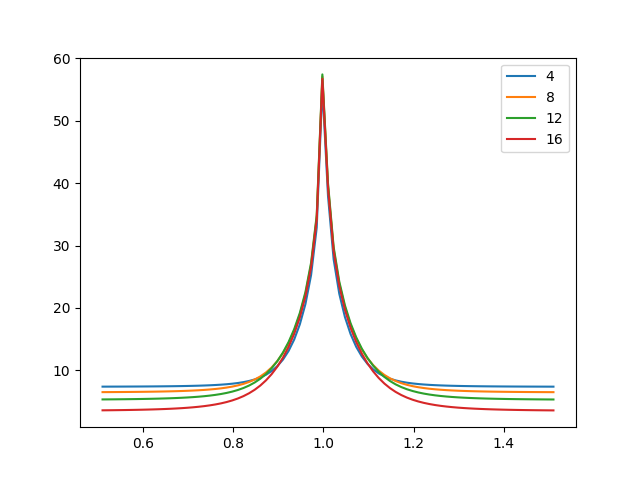

<IPython.core.display.Javascript object>


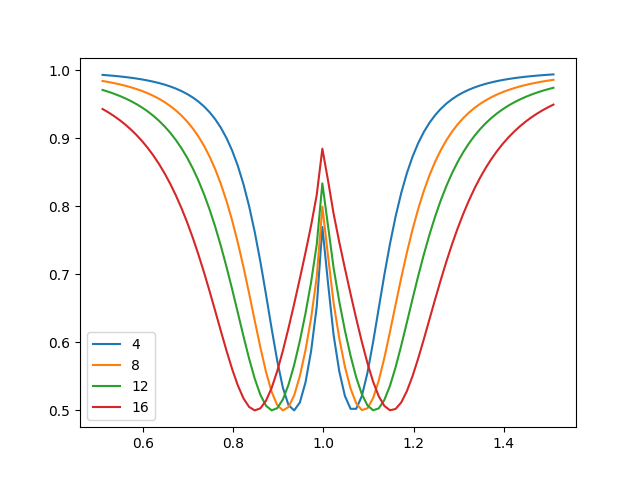

In [11]:
powerB_levels = [4*x for x in range(1,5)]
distances = [0.51 + x/80 for x in range(0,81)]

sc = {'A': (0, 0), 'A_UE': (-0.1, 0), 'B': (1,0), 'B_UE': (1,0)}

results = {}

for p in powerB_levels: 
    results[p] = {}
    sched = {
        1: {1: [('A', 'A_UE', dB(20-p)), ('B', 'B_UE', dB(p)) ]},
        # 1: {1: [('A', 'A_UE', dB(20-p)), ('B_UE', 'B', dB(p)) ]}, 
        # 1: {1: [('A_UE', 'A', dB(20-p)), ('B', 'B_UE', dB(p)) ]}, 
        # 1: {1: [('A_UE', 'A', dB(20-p)), ('B_UE', 'B', dB(p)) ]},         
    }

    for d in distances: 
        sc['B_UE'] = (d, 0)
        dist = scenario.get_distances(sc)
        volumes = compute_datavolume(sched, dist, pl, dr)
        # print(f"Power {p}, dist {d}")
        # pp(volumes)
        
        results[p][d] = (compute_system_rate(volumes)/1024**2, 
                                compute_fairness(volumes)[0],
                                volumes)
        
# pp(results)


plt.figure()
for p in powerB_levels:
    plt.plot(distances, [x[0] for x in results[p].values()], label=f"{p}")
plt.show()
plt.legend()

plt.figure()
for p in powerB_levels:
    plt.plot(distances, [x[1] for x in results[p].values()], label=f"{p}")
plt.show()
plt.legend()
